# PMFT - PMFTXY2D

The PMFT returns the potential energy associated with finding a particle pair in a given spatial (positional and orientational) configuration. The PMFT is computed in the same manner as the RDF. The basic algorithm is described below:

```
for each particle i:
    for each particle j:
        v_ij = position[j] - position[i]
        bin_x, bin_y = convert_to_bin(v_ij)
        pcf_array[bin_y][bin_x]++
```

`freud` uses cell lists and parallelism to optimize this algorithm.

The data sets used in this example are a system of hard hexagons, simulated in the NVT thermodynamic ensemble in HOOMD-blue, for a dense fluid of hexagons at packing fraction $\phi = 0.65$ and solids at packing fractions $\phi = 0.75, 0.85$.

In [1]:
%matplotlib inline
import freud
freud.parallel.setNumThreads(4)
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from helper_functions.polygon import make_polygon
from scipy.ndimage.filters import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 20,
                            'axes.titlesize': 20,
                            'axes.labelsize': 20,
                            'xtick.labelsize': 16,
                            'ytick.labelsize': 16,
                            'savefig.pad_inches': 0.025,
                            'lines.linewidth': 2})

In [2]:
def plot_pmft(data_path, phi):
    # Create the pmft object
    pmft = freud.pmft.PMFTXY2D(x_max=3.0, y_max=3.0, n_x=300, n_y=300)

    # Load the data
    box_data = np.load("{}/box_data.npy".format(data_path))
    pos_data = np.load("{}/pos_data.npy".format(data_path))
    quat_data = np.load("{}/quat_data.npy".format(data_path))
    n_frames = pos_data.shape[0]

    for i in range(1, n_frames):
        # Read box, position data
        l_box = box_data[i].tolist()
        l_pos = pos_data[i]
        l_quat = quat_data[i]
        l_ang = 2*np.arctan2(l_quat[:, 3], l_quat[:, 0])
        l_ang = l_ang % (2 * np.pi)

        pmft.accumulate(l_box, l_pos, l_ang, l_pos, l_ang)

    # Get the value of the PMFT histogram bins
    pmft_arr = np.copy(pmft.PMFT)

    # Do some simple post-processing for plotting purposes
    pmft_arr[np.isinf(pmft_arr)] = np.nan
    dx = (2.0 * 3.0) / pmft.n_bins_X
    dy = (2.0 * 3.0) / pmft.n_bins_Y
    nan_arr = np.where(np.isnan(pmft_arr))
    for i in range(pmft.n_bins_X):
        x = -3.0 + dx * i
        for j in range(pmft.n_bins_Y):
            y = -3.0 + dy * j
            if ((x*x + y*y < 1.5) and (np.isnan(pmft_arr[j, i]))):
                pmft_arr[j, i] = 10.0
    w = int(2.0 * pmft.n_bins_X / (2.0 * 3.0))
    center = int(pmft.n_bins_X / 2)
    
    # Get the center of the histogram bins
    pmft_smooth = gaussian_filter(pmft_arr, 1)
    pmft_image = np.copy(pmft_smooth)
    pmft_image[nan_arr] = np.nan
    pmft_smooth = pmft_smooth[center-w:center+w, center-w:center+w]
    pmft_image = pmft_image[center-w:center+w, center-w:center+w]
    x = pmft.X
    y = pmft.Y
    reduced_x = x[center-w:center+w]
    reduced_y = y[center-w:center+w]

    # Plot figures
    f = plt.figure(figsize=(12, 5))
    values = [-2, -1, 0, 2]
    norm = matplotlib.colors.Normalize(vmin=-2.5, vmax=3.0)
    n_values = [norm(i) for i in values]
    colors = matplotlib.cm.viridis(n_values)
    colors = colors[:, :3]
    verts = make_polygon(sides=6, radius=0.6204)
    lims = (-2, 2)
    ax0 = f.add_subplot(1, 2, 1)
    ax1 = f.add_subplot(1, 2, 2)
    for ax in (ax0, ax1):
        ax.contour(reduced_x, reduced_y, pmft_smooth,
                   [9, 10], colors='black')
        ax.contourf(reduced_x, reduced_y, pmft_smooth,
                    [9, 10], hatches='X', colors='none')
        ax.plot(verts[:,0], verts[:,1], color='black', marker=',')
        ax.fill(verts[:,0], verts[:,1], color='black')
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.xaxis.set_ticks([i for i in range(lims[0], lims[1]+1)])
        ax.yaxis.set_ticks([i for i in range(lims[0], lims[1]+1)])
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        
    ax0.set_title('PMFT Heat Map, $\phi = {}$'.format(phi))
    im = ax0.imshow(np.flipud(pmft_image),
                    extent=[lims[0], lims[1], lims[0], lims[1]],
                    interpolation='nearest', cmap='viridis',
                    vmin=-2.5, vmax=3.0)
    ax1.set_title('PMFT Contour Plot, $\phi = {}$'.format(phi))
    ax1.contour(reduced_x, reduced_y, pmft_smooth,
            [-2, -1, 0, 2], colors=colors)
    
    f.subplots_adjust(right=0.85)
    cbar_ax = f.add_axes([0.88, 0.1, 0.02, 0.8])
    f.colorbar(im, cax=cbar_ax)
    plt.show()

## 65% density
The plot below shows the PMFT of hexagons at 65% density. The hexagons tend to be close to one another, in the darker regions (the lower values of the potential of mean force and torque).

The hatched region near the black hexagon in the center is a region where no data were collected: the hexagons are hard shapes and cannot overlap, so there is an excluded region of space close to the hexagon.

The ring around the hexagon where the PMFT rises and then falls corresponds to the minimum of the radial distribution function -- particles tend to not occupy that region, preferring instead to be at close range (in the first neighbor shell) or further away (in the second neighbor shell).

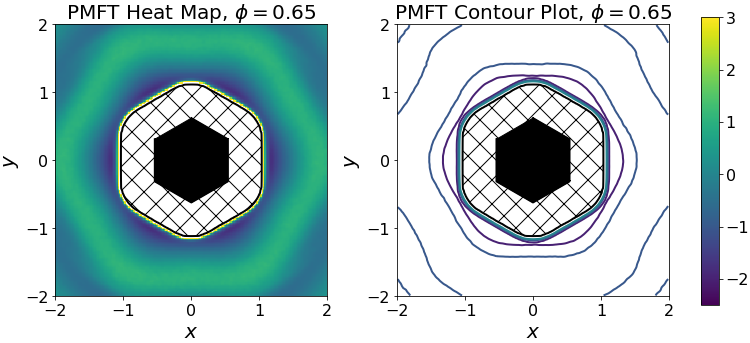

In [3]:
plot_pmft('ex_data/phi065', 0.65)

## 75% density
As the system density is increased to 75%, the propensity for hexagons to occupy the six sites on the faces of their neighbors increases, as seen by the deeper (darker) wells of the PMFT. Conversely, the shapes strongly dislike occupying the yellow regions, and no particle pairs occupied the white region (so there is no data).

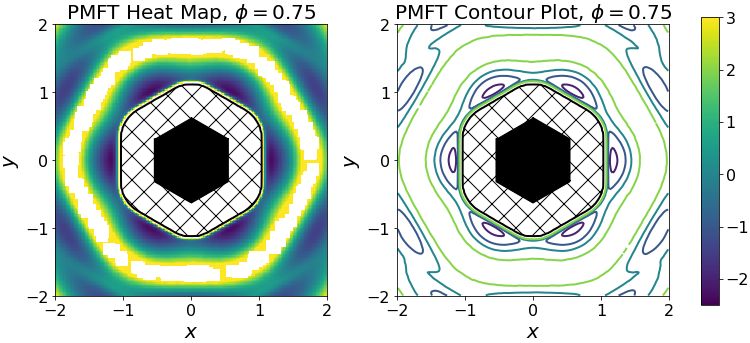

In [4]:
plot_pmft('ex_data/phi075', 0.75)

## 85% density
Finally, at 85% density, there is a large region where no neighbors can be found, and hexagons strictly occupy sites near those of the perfect hexagonal lattice, at the first- and second-neighbor shells. The wells are deeper and much more spatially confined that those of the systems at lower densities.

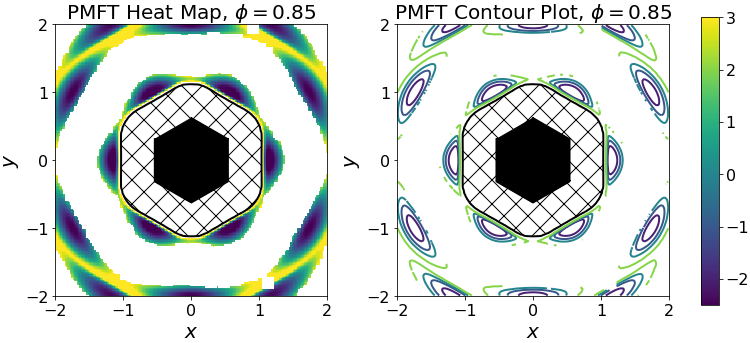

In [5]:
plot_pmft('ex_data/phi085', 0.85)